# Map of GEFS Temperature and Geopotential Height
This notebook loads and plots temperature and 500mb geopotential heights from the mean of the GEFS

### Steps:
1. Import necessary libraries
2. Define constants and helper functions
3. Load, process, and subset the GEFS data
4. Create and display 2m temperature plots for US and NY State


In [1]:
# ---------------------------- Imports ----------------------------
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np

from herbie import Herbie

In [2]:
# ---------------------------- Config -----------------------------
MODEL_RUN = "2025-04-09 12:00"
FORECAST_HOUR = 126

# Lower 48 states
LAT_US_MIN = 21.0
LAT_US_MAX = 54.0
LON_US_MIN = -130.0
LON_US_MAX = -62.0

# NY State
LAT_NY_MIN = 38.5
LAT_NY_MAX = 46.5
LON_NY_MIN = -80.5
LON_NY_MAX = -71.5

import warnings

warnings.filterwarnings( # silence xarray timedelta warning
    "ignore",
    message=".*decode_timedelta will default to False.*",
    category=FutureWarning,
    module="cfgrib.xarray_plugin"
)

In [3]:
# ------------------------ Helper Functions -----------------------

def kelvin_to_fahrenheit(temps):
    """Convert temperatures from Kelvin to Fahrenheit."""
    return (temps - 273.15) * 9/5 + 32

def create_temperature_colormap():
    """Create a custom colormap for 2m temperature in Fahrenheit."""
    a = np.arange(-60, 121, 5)
    norm = [(float(i) - min(a)) / (max(a) - min(a)) for i in a]
    C = np.array([
        [145, 0, 63], [206, 18, 86], [231, 41, 138], [223, 101, 176],
        [255, 115, 223], [255, 190, 232], [255, 255, 255], [218, 218, 235],
        [188, 189, 220], [158, 154, 200], [117, 107, 177], [84, 39, 143],
        [13, 0, 125], [13, 61, 156], [0, 102, 194], [41, 158, 255],
        [74, 199, 255], [115, 215, 255], [173, 255, 255], [48, 207, 194],
        [0, 153, 150], [18, 87, 87], [6, 109, 44], [49, 163, 84],
        [116, 196, 118], [161, 217, 155], [211, 255, 190], [255, 255, 179],
        [255, 237, 160], [254, 209, 118], [254, 174, 42], [253, 141, 60],
        [252, 78, 42], [227, 26, 28], [177, 0, 38], [128, 0, 38],
        [89, 0, 66], [40, 0, 40]
    ]) / 255.
    return mcolors.LinearSegmentedColormap.from_list("Temperature", list(zip(norm, C)))

def download_and_process_gefs_data(model_run, forecast_hour):
    """
    Download and process the GEFS model data.
    
    Parameters:
    - model_run: Date and time of the model run.
    - forecast_hour: Forecast hour to retrieve.
    
    Returns:
    - tmp_2m: Processed 2-meter temperature data.
    - hgt_500mb: Processed 500mb geopotential height data.
    """

    # Initialize Herbie and download the data
    H = Herbie(model_run, model="gefs", product="atmos.5", member="mean", fxx=forecast_hour)

    # Load temperature and geopotential height datasets
    tmp_2m = H.xarray("TMP:2 m")
    hgt_500mb = H.xarray("HGT:500 mb")

    # Preserve existing attributes
    original_attrs = tmp_2m['t2m'].attrs.copy()

    # Convert t2m to Fahrenheit
    tmp_2m['t2m'] = kelvin_to_fahrenheit(tmp_2m['t2m'])

    # Restore all original attributes, and update units
    tmp_2m['t2m'].attrs = original_attrs
    tmp_2m['t2m'].attrs['units'] = '°F'

    return tmp_2m, hgt_500mb

def subset_gefs_data(temp, height, lon_min, lon_max, lat_min, lat_max):
    """
    Subset the GEFS data to the specified latitude and longitude bounds.
    
    Parameters:
    - temp: The processed temperature data.
    - height: The processed geopotential height data.
    - lon_min, lon_max: Longitude bounds for the subset.
    - lat_min, lat_max: Latitude bounds for the subset.
    
    Returns:
    - temp_subset: Subsetted temperature data.
    - height_subset: Subsetted geopotential height data.
    """
    # Adjust longitudes if necessary
    if temp.longitude.max() > 180:
        lon_min = lon_min % 360
        lon_max = lon_max % 360

    # Subset the data by the selected region
    temp_subset = temp.sel(longitude=slice(lon_min, lon_max), latitude=slice(lat_max, lat_min))
    height_subset = height.sel(longitude=slice(lon_min, lon_max), latitude=slice(lat_max, lat_min))

    return temp_subset, height_subset

def plot_temperature_and_height(temp, height, cmap):
    """Plot temperature with height contours."""
    fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})
    
    ax.coastlines()
    ax.add_feature(cfeature.STATES, linestyle=':')
    ax.add_feature(cfeature.BORDERS, linestyle='-')

    tplot = ax.pcolormesh(temp.longitude, temp.latitude, temp.t2m, transform=ccrs.PlateCarree(),
                          cmap=cmap, vmin=-60, vmax=120)
    
    plt.colorbar(tplot, ax=ax, orientation="horizontal", pad=0.01, shrink=0.6,
                 label=f"{temp.t2m.GRIB_name} ({temp.t2m.GRIB_units})")

    ax.contour(height.longitude, height.latitude, height.gh, colors="k", linewidths=0.5, levels=range(0, 10000, 120))

    ax.set_title(
        f"{temp.model.upper()} ensemble mean\nValid: {temp.valid_time.dt.strftime('%H:%M UTC %d %b %Y').item()}",
        loc="left")
    ax.set_title(temp.t2m.GRIB_name, loc="right")

    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = gl.ylabels_right = False
    gl.xlabel_style = gl.ylabel_style = {'size': 10, 'color': 'black'}
    gl.xlocator = gl.ylocator = plt.MaxNLocator(integer=True)

    plt.tight_layout()
    plt.show()

✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2025-Apr-09 12:00 UTC F126 ┊ GRIB2 @ aws ┊ IDX @ aws


/opt/anaconda3/envs/GEFS_plot/lib/python3.10/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/opt/anaconda3/envs/GEFS_plot/lib/python3.10/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


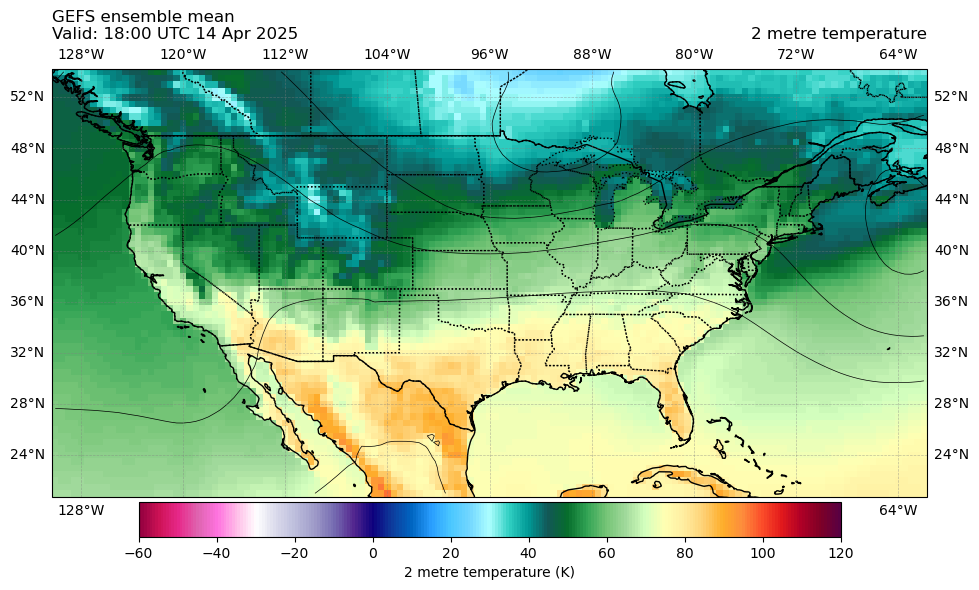

✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2025-Apr-09 12:00 UTC F126 ┊ GRIB2 @ aws ┊ IDX @ aws


/opt/anaconda3/envs/GEFS_plot/lib/python3.10/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/opt/anaconda3/envs/GEFS_plot/lib/python3.10/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


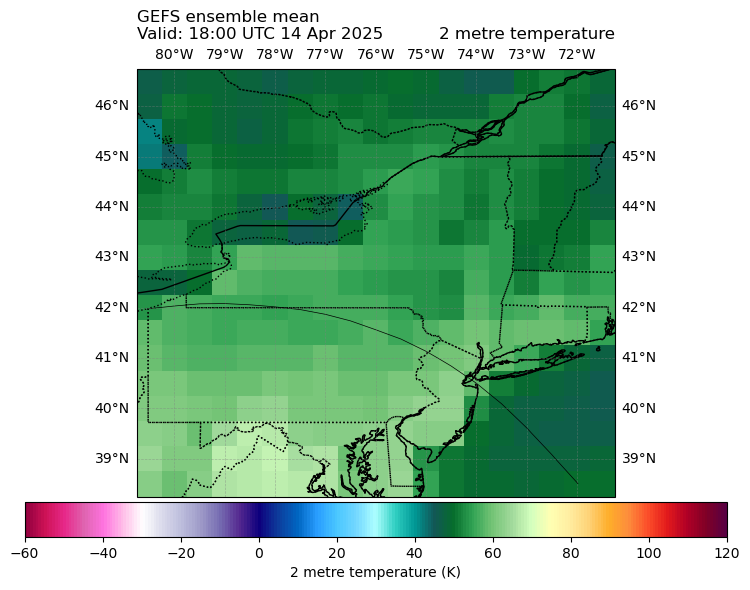

In [4]:
# ----------------------------- Main ------------------------------
# Create the colormap
cmap = create_temperature_colormap()

# Load, subset, and plot data for US Map
temp, height = download_and_process_gefs_data(MODEL_RUN, FORECAST_HOUR)
temp_subset, height_subset = subset_gefs_data(temp, height, LON_US_MIN, LON_US_MAX, LAT_US_MIN, LAT_US_MAX)
plot_temperature_and_height(temp_subset, height_subset, cmap)

# Load, subset, and plot data for NY Map
temp, height = download_and_process_gefs_data(MODEL_RUN, FORECAST_HOUR)
temp_subset, height_subset = subset_gefs_data(temp, height, LON_NY_MIN, LON_NY_MAX, LAT_NY_MIN, LAT_NY_MAX)
plot_temperature_and_height(temp_subset, height_subset, cmap)
